In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
DDoS=pd.read_csv('/content/dataset_sdn.csv')

In [ ]:
DDoS.columns

Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes',
       'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'label'],
      dtype='object')

In [ ]:
#Transformations of categorical features
DDoS['Protocol'] = DDoS['Protocol'].astype('category')
DDoS['src'] = DDoS['src'].astype('category')
DDoS['dst'] = DDoS['dst'].astype('category')

cat_columns = DDoS.select_dtypes(['category']).columns
DDoS[cat_columns] = DDoS[cat_columns].apply(lambda x: x.cat.codes)

In [ ]:
DDoS["rx_kbps"] = DDoS["rx_kbps"].fillna(DDoS["rx_kbps"].mean())

In [ ]:
DDoS["tot_kbps"] = DDoS["tot_kbps"].fillna(DDoS["tot_kbps"].mean())

In [ ]:
from sklearn.model_selection import train_test_split
X = DDoS[['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes',
       'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps']]
y = DDoS['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Feature scaling (or standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
!pip install pytorch-tabnet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
# define the model
model= TabNetClassifier(optimizer_fn=torch.optim.Adam,n_d=8,n_a=8,n_steps=3,
                       optimizer_params=dict(lr=0.005),
                       scheduler_params={"step_size":5, # how to use learning rate scheduler
                                         "gamma":0.2},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax'
                      )

Device used : cpu


In [ ]:
# fit the model 
model.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy','accuracy'],
    max_epochs=20 ,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=True
)  

epoch 0  | loss: 0.28914 | train_balanced_accuracy: 0.95032 | train_accuracy: 0.94579 | valid_balanced_accuracy: 0.95258 | valid_accuracy: 0.94791 |  0:00:09s
epoch 1  | loss: 0.09939 | train_balanced_accuracy: 0.94392 | train_accuracy: 0.93544 | valid_balanced_accuracy: 0.943   | valid_accuracy: 0.93498 |  0:00:20s
epoch 2  | loss: 0.06919 | train_balanced_accuracy: 0.96105 | train_accuracy: 0.95424 | valid_balanced_accuracy: 0.96097 | valid_accuracy: 0.95424 |  0:00:29s
epoch 3  | loss: 0.05619 | train_balanced_accuracy: 0.9531  | train_accuracy: 0.94412 | valid_balanced_accuracy: 0.95251 | valid_accuracy: 0.94331 |  0:00:37s
epoch 4  | loss: 0.05392 | train_balanced_accuracy: 0.98417 | train_accuracy: 0.98113 | valid_balanced_accuracy: 0.98379 | valid_accuracy: 0.98083 |  0:00:46s
epoch 5  | loss: 0.04524 | train_balanced_accuracy: 0.98277 | train_accuracy: 0.97925 | valid_balanced_accuracy: 0.98261 | valid_accuracy: 0.9792  |  0:00:56s
epoch 6  | loss: 0.04179 | train_balanced_accu

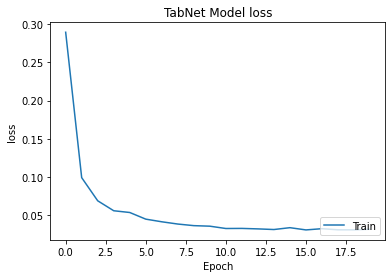

In [ ]:
# plot losses
plt.plot(model.history['loss'])
plt.title('TabNet Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('TabNet Model loss.png')
plt.show()

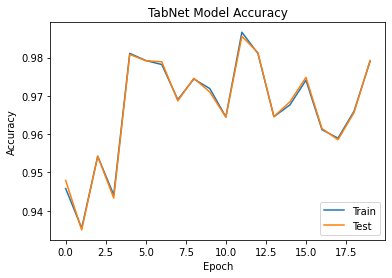

In [ ]:
# plot accuracy
plt.plot(model.history['train_accuracy'])
plt.plot(model.history['valid_accuracy'])
plt.title('TabNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('TabNet Model Accuracy.png')
plt.show()

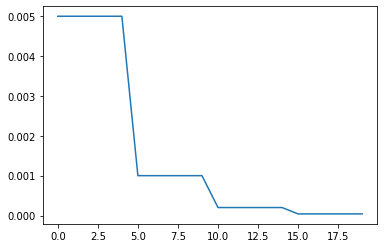

In [ ]:
# plot learning rates
plt.plot(model.history['lr'])

In [ ]:
# local explainability and masks
explain_matrix, masks = model.explain(X_test)

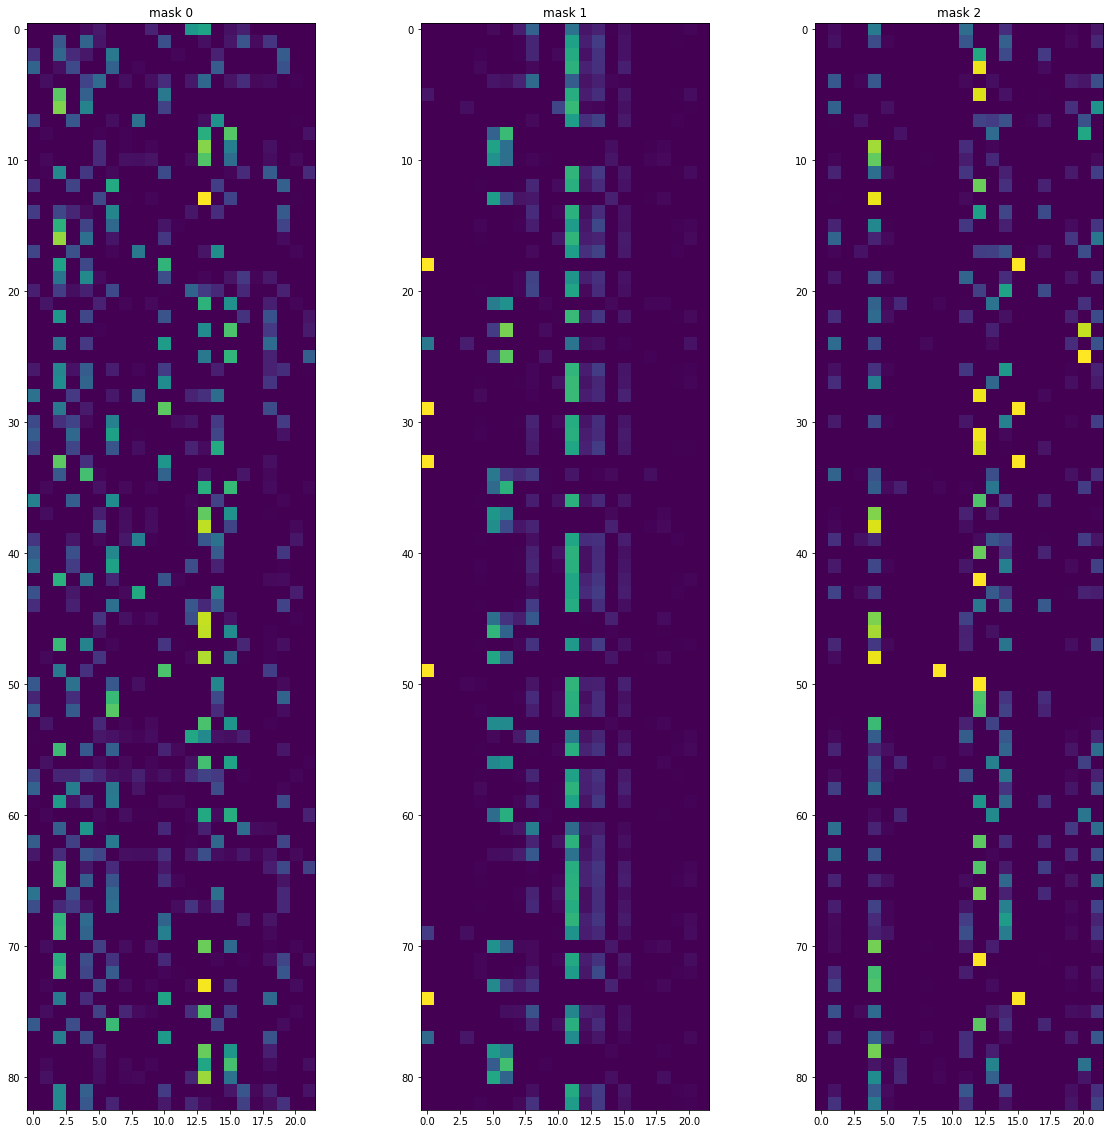

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:83])
    axs[i].set_title(f"mask {i}")

In [ ]:
#prediction
y_pred = model.predict(X_test)

In [ ]:
# determine best accuracy for test set
preds = model.predict(X_test)
test_acc = accuracy_score(preds, y_test)
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")

BEST ACCURACY SCORE ON TEST SET : 0.985576692702094
